In [19]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, average_precision_score, precision_recall_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.externals.six import StringIO  
from IPython.display import Image  

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import export_graphviz

import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pydot
import scikitplot as skplt

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

bank_data = pd.read_csv('bank-additional-full.csv')

In [2]:
#Handling categorical variables
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','day_of_week', 'poutcome', 'y']
bank_data_tran = pd.get_dummies(bank_data, columns = categorical_features, drop_first=True)

bank_data_tran.drop(['duration'], axis = 1, inplace = True)
bank_data_tran.drop(['job_blue-collar', 'job_self-employed', 'job_services', 'job_unemployed', 'day_of_week_mon'], axis = 1, inplace = True)
#because of the high correlation coefficient between euribor3m rate and nr. of employed, the latter is going to be dropped
bank_data_tran.drop(['nr.employed'], axis = 1, inplace = True)

#apllying the same logic, emp.var.rate is going to be dropped
bank_data_tran.drop(['emp.var.rate'], axis = 1, inplace = True)

In [3]:
#Function for printing results
def print_results(x_input, true_output, predicted_output, classifier):
    precision, recall, thresholds = precision_recall_curve(true_output, classifier.predict_proba(x_input)[:,1])
    area = auc(recall, precision)
    print("\nArea under precission-recall is:", area)
    
    print("Validation set predictions: \n\n" + classification_report(true_output,predicted_output))
    print("\n Confusion matrix:\n " , confusion_matrix(true_output, predicted_output))
    print("\n")
    print("True negatives:", confusion_matrix(true_output, predicted_output)[0][0])
    print("False positives:", confusion_matrix(true_output, predicted_output)[0][1])
    print("False negatives:", confusion_matrix(true_output, predicted_output)[1][0])
    print("True positives: ", confusion_matrix(true_output, predicted_output)[1][1])

In [4]:
#Data preprocessing and splitting and scaling
msk = np.random.rand(len(bank_data_tran)) < 0.8

train = bank_data_tran[msk]
test = bank_data_tran[~msk]

msk2 = np.random.rand(len(train)) < 0.8

train2 = train[msk2]
val = train[~msk2]


x = bank_data_tran.iloc[:,bank_data_tran.columns != 'y_yes'].values
y = bank_data_tran.iloc[:, -1].values

In [5]:
#Downsampled

# Separate majority and minority classes
df_majority = train2[train2.y_yes ==0]
df_minority = train2[train2.y_yes ==1]

In [6]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 random_state=123) # reproducible results

In [7]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [8]:
df_downsampled.y_yes.value_counts()

0    5000
1    2949
Name: y_yes, dtype: int64

In [9]:
#Data preprocessing and splitting 
x_down = df_downsampled.iloc[:,df_downsampled.columns != 'y_yes'].values
y_down = df_downsampled.iloc[:, -1].values

x_train = x_down
y_train = y_down

x_val = val.iloc[:, val.columns != 'y_yes'].values
y_val = val.iloc[:, -1].values

x_test = test.iloc[:, test.columns!='y_yes'].values
y_test = test.iloc[:, -1].values

# Decision tree
   - <h4> Model training </h4>

In [65]:
#Decision tree algorithm
td_classifier = DecisionTreeClassifier(criterion='entropy', random_state = 0)
td_classifier.fit(x_train, y_train)

predictions_DT_val = td_classifier.predict(x_val)

#Results 
print_results(x_val, y_val, predictions_DT_val, td_classifier)


Area under precission-recall is: 0.3972913709330861
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.75      0.83      5926
          1       0.21      0.55      0.30       703

avg / total       0.86      0.73      0.77      6629


 Confusion matrix:
  [[4438 1488]
 [ 318  385]]


True negatives: 4438
False positives: 1488
False negatives: 318
True positives:  385


- <h4> Model testing </h4>

In [23]:
predictions_DT_test = td_classifier.predict(x_test)
print_results(x_test, y_test, predictions_DT_test, td_classifier)


Area under precission-recall is: 0.41209428261746445
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.74      0.82      7322
          1       0.21      0.56      0.31       929

avg / total       0.85      0.72      0.77      8251


 Confusion matrix:
  [[5410 1912]
 [ 408  521]]


True negatives: 5410
False positives: 1912
False negatives: 408
True positives:  521


# AdaBoost
- <h4> Model training </h4>

In [11]:
#Boosting - AdaBoost
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20),
                         algorithm = "SAMME",
                         n_estimators=200)
                         
ada.fit(x_train, y_train)
predictions_ada = ada.predict(x_val)

print_results(x_val, y_val, predictions_ada, ada)


Area under precission-recall is: 0.4108815335797853
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.84      0.88      5727
          1       0.32      0.56      0.41       776

avg / total       0.86      0.81      0.83      6503


 Confusion matrix:
  [[4803  924]
 [ 340  436]]


True negatives: 4803
False positives: 924
False negatives: 340
True positives:  436


- <h4> Model testing </h4>

In [33]:
predictions_ada_test = ada.predict(x_test)
print_results(x_test, y_test, predictions_ada_test, ada)


Area under precission-recall is: 0.11043810289833872
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.84      0.09      0.17      7379
          1       0.11      0.87      0.19       938

avg / total       0.76      0.18      0.17      8317


 Confusion matrix:
  [[ 680 6699]
 [ 125  813]]


True negatives: 680
False positives: 6699
False negatives: 125
True positives:  813


# Gradient Boosting  Classifier
- <h4> Model training </h4>

In [12]:
#Gradient boosting
gradientBoost = GradientBoostingClassifier(n_estimators=100, random_state=1)
gradientBoost.fit(x_train, y_train)

gradient_predictions = gradientBoost.predict(x_val)

#Results
print_results(x_val, y_val, gradient_predictions, gradientBoost)


Area under precission-recall is: 0.4961052116096427
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.94      0.91      0.92      5727
          1       0.46      0.57      0.51       776

avg / total       0.88      0.87      0.88      6503


 Confusion matrix:
  [[5209  518]
 [ 331  445]]


True negatives: 5209
False positives: 518
False negatives: 331
True positives:  445


- <h4> Model testing </h4>

In [38]:
predictions_GradB_test = gradientBoost.predict(x_test)
print_results(x_test, y_test, predictions_GradB_test, classifier=gradientBoost)


Area under precission-recall is: 0.28162879856849043
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.95      0.24      0.39      7379
          1       0.13      0.91      0.23       938

avg / total       0.86      0.32      0.37      8317


 Confusion matrix:
  [[1802 5577]
 [  87  851]]


True negatives: 1802
False positives: 5577
False negatives: 87
True positives:  851


# Decision Tree Bagging
- <h4> Model training </h4>

In [13]:
#Bagging with decission trees
bagg = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=100, random_state=7)
bagg.fit(x_train, y_train)

predictions_bag = bagg.predict(x_val)

#Results
print_results(x_val, y_val, predictions_bag, bagg)


Area under precission-recall is: 0.4720703753295393
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.94      0.89      0.91      5727
          1       0.41      0.58      0.48       776

avg / total       0.88      0.85      0.86      6503


 Confusion matrix:
  [[5079  648]
 [ 323  453]]


True negatives: 5079
False positives: 648
False negatives: 323
True positives:  453


- <h4> Model testing </h4>

In [39]:
predictions_bagg_test = bagg.predict(x_test)
print_results(x_test, y_test, predictions_bagg_test, bagg)


Area under precission-recall is: 0.1533259650779794
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.92      0.61      0.73      7379
          1       0.16      0.59      0.25       938

avg / total       0.84      0.61      0.68      8317


 Confusion matrix:
  [[4480 2899]
 [ 382  556]]


True negatives: 4480
False positives: 2899
False negatives: 382
True positives:  556


# Random Forest Classifier
- <h4> Model training </h4>

In [66]:
#Random Forest Classification Algorithm

# Fitting Random Forest Classification to the Training set
rf_classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 0)
rf_classifier.fit(x_train, y_train)

# Predicting the Test set results
predictions_RF_val = rf_classifier.predict(x_val)

# Making the Confusion Matrix
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_val, predictions_RF)

#Results
print_results(x_val, y_val, predictions_RF_val, rf_classifier)


Area under precission-recall is: 0.38590103097403483
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.95      0.85      0.89      5926
          1       0.31      0.59      0.41       703

avg / total       0.88      0.82      0.84      6629


 Confusion matrix:
  [[5023  903]
 [ 291  412]]


True negatives: 5023
False positives: 903
False negatives: 291
True positives:  412


- <h4> Model testing </h4>

In [35]:
predictions_RF_test = rf_classifier.predict(x_test)
print_results(x_test, y_test, predictions_RF_test, rf_classifier)



Area under precission-recall is: 0.40510349441411486
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.94      0.88      0.91      7379
          1       0.38      0.57      0.46       938

avg / total       0.88      0.85      0.86      8317


 Confusion matrix:
  [[6493  886]
 [ 400  538]]


True negatives: 6493
False positives: 886
False negatives: 400
True positives:  538


In [10]:
# Feature Scaling, because it isn't needed for Random Forest and Decision trees
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

# Logistic Regression Classifier
- <h4> Model training 

In [11]:
#Logistic Regression Algorithm
logdown = LogisticRegression(class_weight = 'balanced')
logdown.fit(x_train, y_train)
predictions_LR = logdown.predict(x_val)

#Results
print_results(x_val, y_val, predictions_LR, logdown)


Area under precission-recall is: 0.45131939695851836
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.95      0.85      0.89      5911
          1       0.34      0.63      0.45       758

avg / total       0.88      0.82      0.84      6669


 Confusion matrix:
  [[5007  904]
 [ 282  476]]


True negatives: 5007
False positives: 904
False negatives: 282
True positives:  476


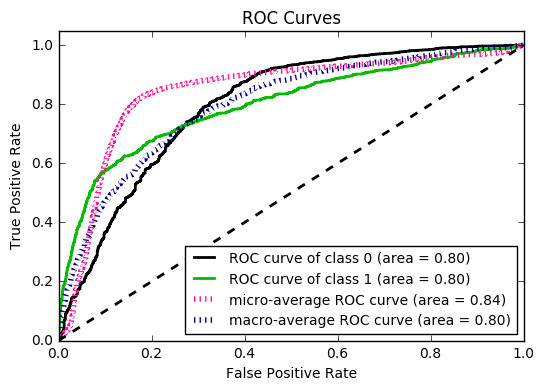

In [12]:
y_true = y_val
y_probas = logdown.predict_proba(x_val)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

In [15]:
roc_auc_score(y_val, predictions_LR, average='macro', sample_weight=None)

0.7375165660909471

- <h4> Model testing


In [ ]:
predictions_LR_test = logdown.predict(x_test)
print_results(x_test, y_test, predictions_LR_test, logdown)

# Support Vector Machines Classifier
- <h4> Model training 

In [17]:
#SVM algorithm

svm_classifier = SVC(kernel = 'rbf', random_state = 0, probability = True)
svm_classifier.fit(x_train, y_train)
predictions_SVC_val = svm_classifier.predict(x_val)

#Results
print_results(x_val, y_val, predictions_SVC_val, svm_classifier)
roc_auc_score(y_val, predictions_SVC_val, average='macro', sample_weight=None)


Area under precission-recall is: 0.39719496556553907
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.94      0.90      0.92      5911
          1       0.44      0.58      0.50       758

avg / total       0.89      0.87      0.87      6669


 Confusion matrix:
  [[5340  571]
 [ 318  440]]


True negatives: 5340
False positives: 571
False negatives: 318
True positives:  440


0.7419376869474157

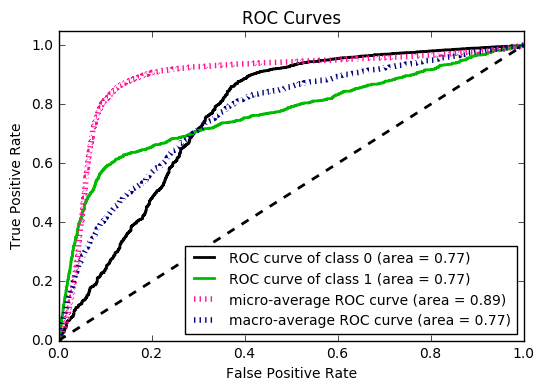

In [18]:
y_true = y_val
y_probas = svm_classifier.predict_proba(x_val)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

- <h4> Model testing

In [46]:
predictions_SVM_test = svm_classifier.predict(x_test)

#Results
print_results(x_test, y_test, predictions_SVM_test, svm_classifier)


Area under precission-recall is: 0.3421175975661513
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.94      0.90      0.92      7350
          1       0.40      0.53      0.46       922

avg / total       0.88      0.86      0.87      8272


 Confusion matrix:
  [[6626  724]
 [ 430  492]]


True negatives: 6626
False positives: 724
False negatives: 430
True positives:  492


# K-Nearest Neighbours Classifier
- <h4> Model training

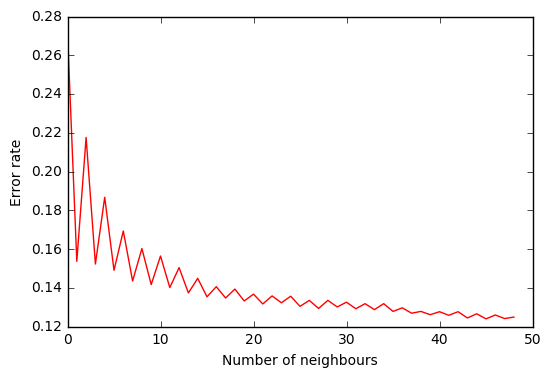

In [22]:
#KNN Algorithm
#adjusting parameters for KNN
error_rate = []

# Will take some time
for i in range(1,50):  
    knn_classifier = KNeighborsClassifier(n_neighbors=i, metric = 'minkowski', p = 2)
    knn_classifier.fit(x_train, y_train)
    pred_i = knn_classifier.predict(x_val)
    error_rate.append(np.mean(pred_i != y_val))
    
plt.xlabel("Number of neighbours")
plt.ylabel("Error rate")
plt.plot(error_rate, "r")

#predictions_KNN_test = knn_classifier.predict(x_test)
#print("Test set predictions:\n\n" + classification_report(y_test, predictions_KNN_test))

In [28]:
np.argmin(error_rate)

45

In [30]:
#From the plot above, we can see that the error_rate is smallest when number of neighbours is 17, so we take that K value
knn_classifier = KNeighborsClassifier(n_neighbors=45, metric = 'minkowski', p = 2)
knn_classifier.fit(x_train, y_train)
pred_i = knn_classifier.predict(x_val)

#Results
print_results(x_val, y_val, pred_i, knn_classifier)


Area under precission-recall is: 0.44392430145609363
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.93      0.93      5727
          1       0.47      0.47      0.47       776

avg / total       0.87      0.87      0.87      6503


 Confusion matrix:
  [[5318  409]
 [ 414  362]]


True negatives: 5318
False positives: 409
False negatives: 414
True positives:  362


- <h4> Model testing

In [44]:
predictions_KNN_test = knn_classifier.predict(x_test)
print_results(x_test, y_test, predictions_KNN_test, knn_classifier)


Area under precission-recall is: 0.3696897362459471
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.93      0.93      7379
          1       0.43      0.43      0.43       938

avg / total       0.87      0.87      0.87      8317


 Confusion matrix:
  [[6835  544]
 [ 535  403]]


True negatives: 6835
False positives: 544
False negatives: 535
True positives:  403


# Gaussian Naive Bayes Classifier
- <h4> Model training


In [45]:
# Gaussian Naive Bayes
gaussian_classifier = GaussianNB()
gaussian_classifier.fit(x_train, y_train)
#print(gaussian_classifier)
# make predictions
predicted = gaussian_classifier.predict(x_val)
# summarize the fit of the model

print_results(x_val, y_val, predicted, gaussian_classifier)


Area under precission-recall is: 0.44785155274595245
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.95      0.55      0.69      5727
          1       0.19      0.78      0.30       776

avg / total       0.86      0.57      0.65      6503


 Confusion matrix:
  [[3129 2598]
 [ 169  607]]


True negatives: 3129
False positives: 2598
False negatives: 169
True positives:  607
